# Noise Interferometry Test
This tests the functionality of the noise interferometry module of ooipy

## Sections
- Compute Cross Correlation for specified window

First, let's import all dependancies

In [3]:
import os
import sys
cwd = os.getcwd()
ooipy_dir = os.path.dirname(cwd) + '/ooipy'
sys.path.append(ooipy_dir)
from matplotlib import pyplot as plt
import datetime
import numpy as np
from obspy import read,Stream, Trace
from obspy.core import UTCDateTime
from ooipy.hydrophone import Noise_Interferometry as NI
import pickle
import scipy
from gwpy.timeseries import TimeSeries
import seaborn as sns
import gwpy
import progressbar

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Calculating NCF for 1 Average Period

In [2]:
# Create instance of NCF object
avg_time = 60 #minute
start_time = datetime.datetime(2017,3,10,0,0,0)
node1 = '/LJ01C'
node2 = '/PC01A'
filter_cutoffs = [20, 70]
W = 30

NCF0 = NI.NCF(avg_time, start_time, node1, node2, filter_cutoffs, W, verbose=True, whiten=True)
NCF0 = NI.calculate_NCF(NCF0)

plt.plot(NCF0.NCF)

   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 66.16511726379395 




# Loop Through 2 instances of NCF Calculation

In [6]:
NI.calculate_NCF_loop(2, node1, node2, 1, start_time, W,  filter_cutoffs, verbose=True, whiten=True)

Calculting NCF for Period 1:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.200584411621094 


Calculting NCF for Period 2:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.003805160522461 




# NCF_analysis toolset

2017-03-10 00:00:00
[  0.5  30. ]
low_frequency
300
Central_Caldera
Eastern_Caldera
30
sabra
Experimenting with smaller frequency band
Number of Available hours: 263
7.33e+06


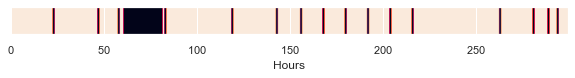

<Figure size 432x288 with 0 Axes>

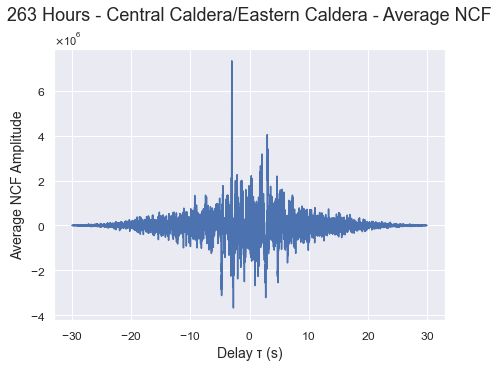

In [5]:
import NCF_analysis as NCF
file_name = "/Volumes/John's Passport/University of Washington/NCFs/ckpts_14"
exp1 = NCF.NCF_analysis(file_name)

exp1.read_header()
exp1.available_hours()

fig2 = plt.figure()
xcorr = exp1.average_NCF(0,500, plot=True)

scientific_notation = "{:.2e}".format(np.max(np.abs(xcorr)))
print(scientific_notation)

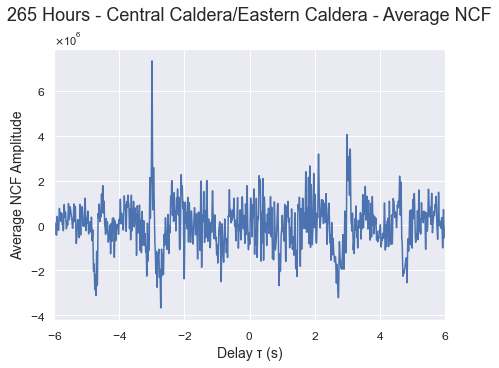

In [8]:
# Save Figure

exp1.NCF_plot(exp1.xcorr, 265, save_fig=False,file_name = 'Central_Axial_hydrophone_zoomed', frequency=False, symetric=False, xlimits=[-6, 6])

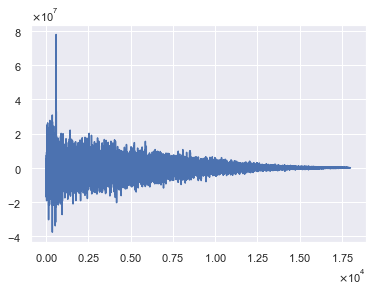

In [7]:
# Create Sum of Both Sides
import math as m

xcorr1 = xcorr[:m.floor(len(xcorr)/2)]
xcorr2 = xcorr[m.ceil(len(xcorr)/2):]

plt.plot(xcorr2 + np.flip(xcorr1))

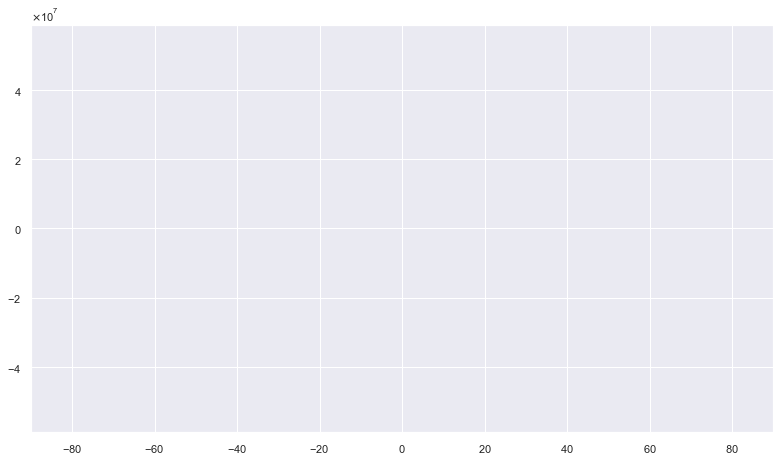

In [45]:
exp1.animate_NCF(500, 10, 'Eastern_Central', interval=1)

# Create Spectrogram of NCF

Text(0, 0.5, 'Frequency (Hz)')

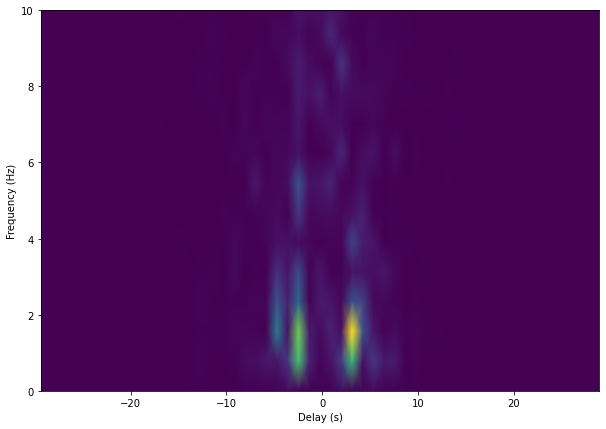

In [13]:
f, t, Sxx = scipy.signal.spectrogram(xcorr, fs=200)
t = t-30
sns.reset_orig()
fig1 = plt.figure(figsize=(10,7))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim([0,10])
#plt.xlim([-28,-10])
plt.xlabel('Delay (s)')
plt.ylabel('Frequency (Hz)')
#fig1.savefig('spectrogram_NCF_central_eastern_hyrophone.png',dpi=500)

# Editing Header File
For specific edits, hard code change the function NCF_tools.edit_header()

In [20]:
import NCF_analysis as NCF

exp1 = NCF.NCF_analysis('ckpts_12')
exp1.edit_header()

exp1.read_header()

2017-03-10 00:00:00
[ 1 90]
low_frequency
500
Central_Caldera
Axial_Base
90
sabra
Using Correct hydrophone Channel but without sensitivity correction
2017-03-10 00:00:00
[ 1 90]
low_frequency
1000
Central_Caldera
Axial_Base
90
sabra
Using Correct hydrophone Channel but without sensitivity correction
